In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt
import torchvision.models as models
import pathlib
import os
import tqdm
from IPython.display import display

from model import ValFolder

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [94]:
data_dir = pathlib.Path('./data/tiny-imagenet-200')
image_count = len(list(data_dir.glob('**/*.JPEG')))
CLASS_NAMES = np.array([item.name for item in (data_dir / 'train').glob('*')])
print('Discovered {} images'.format(image_count))

Discovered 120000 images


In [97]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    model.fc,
    nn.ReLU(inplace=True),
    nn.Linear(1000, 200)
)

In [98]:
# Create the training data generator
batch_size = 128

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.4805, 0.4483, 0.3978), (0.2177, 0.2138, 0.2136))
])

augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomGrayscale(0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Pad(5, padding_mode='reflect'),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.RandomCrop(64),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4805, 0.4483, 0.3978), (0.2177, 0.2138, 0.2136))
])
original_set = torchvision.datasets.ImageFolder(data_dir / 'train', data_transforms)
augmented_set = torchvision.datasets.ImageFolder(data_dir / 'train', augment_transforms)
train_set = torch.utils.data.ConcatDataset([original_set, augmented_set])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=4, pin_memory=True)
    

val_set = ValFolder(CLASS_NAMES, data_dir / 'val', data_transforms)
val_set.__getitem__(1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=True, num_workers=4, pin_memory=True)

In [84]:
# for i in range(10):
#     im = transforms.ToPILImage()(train_set.__getitem__(i)[0]).convert("RGB")
#     display(im)

In [85]:
# mean = 0
# std = 0

# for images, _ in train_loader:
#     batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
    
# mean /= len(train_loader.dataset)
# std /= len(train_loader.dataset)
# print(mean, std)

In [102]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
num_epochs = 5
lr = 1e-3

model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim, lr_lambda=lambda epoch: 0.9)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for i in range(num_epochs):
    model.train()
    train_total, train_correct = 0,0
    for idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss.item())
        
        loss.backward()
        optim.step()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        if idx % 10 ==0:
            print(f'training {100 * idx / len(train_loader):.2f}%: {train_correct / train_total:.3f}. Loss: {loss.item()}')
    
    torch.save({
        'net': model.state_dict(),
    }, 'latest.pt')
    
    model.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        val_total, val_correct = 0,0
        for idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss_epoch += loss.item()

            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            if idx % 10 ==0:
                print(f'val {100 * idx / len(val_loader):.2f}%: {val_correct / val_total:.3f}. Loss: {loss.item()}')
            
    val_losses.append(val_loss_epoch)
    scheduler.step()

training 0.00%: 0.680. Loss: 1.2145490646362305
training 0.64%: 0.704. Loss: 0.9909160733222961
training 1.28%: 0.682. Loss: 1.2925530672073364
training 1.92%: 0.679. Loss: 1.3406039476394653
training 2.56%: 0.675. Loss: 1.2782889604568481
training 3.20%: 0.673. Loss: 1.0538113117218018
training 3.84%: 0.676. Loss: 1.056845784187317
training 4.48%: 0.678. Loss: 1.0031429529190063
training 5.12%: 0.679. Loss: 1.0989044904708862
training 5.76%: 0.679. Loss: 1.2831650972366333
training 6.40%: 0.680. Loss: 1.3490936756134033
training 7.04%: 0.680. Loss: 1.2137974500656128
training 7.68%: 0.679. Loss: 1.5067211389541626
training 8.32%: 0.679. Loss: 1.3348450660705566
training 8.96%: 0.678. Loss: 1.3114489316940308
training 9.60%: 0.677. Loss: 1.6009076833724976
training 10.24%: 0.677. Loss: 1.2770167589187622
training 10.88%: 0.677. Loss: 1.3261774778366089
training 11.52%: 0.677. Loss: 1.269918441772461
training 12.16%: 0.675. Loss: 1.2551445960998535
training 12.80%: 0.675. Loss: 1.185925

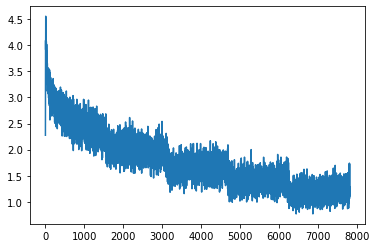

In [104]:
plt.plot(train_losses)

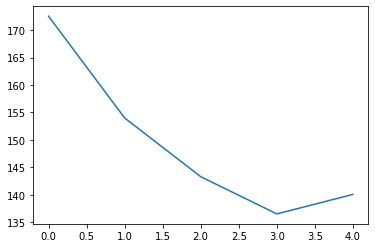

In [105]:
plt.plot(val_losses)